In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.api import abline_plot 
from sklearn.metrics import mean_squared_error, r2_score 
from sklearn.model_selection import train_test_split 
from sklearn import linear_model, preprocessing 
from datetime import datetime, timezone

The project seeks to predict the duration of dangerous air quality due to wildfire season in San Francisco, and is planned to apply to New York City during Canadian wildfire season with the pertinent data.

For context on data wrangling, file sets, and some previous EDA: https://github.com/UnacceptableVegetable/SpringBoard/blob/main/Capstone%20Two/data_wrangling.ipynb

The dataset is a merging of datasets from the CDC and ASOS containing the target feature 'DS_PM_pred': Mean estimated 24-hour average PM2.5 concentration in μg/m3, the location of weather stations, temperature, relative humidity, and wind speed/direction. 

I decided that I should focus on only the San Francisco station (for now), so I needed to be able to read the large CSV file and then write a new CSV file with only SFO's station data and nearby PM2.5 recordings.

In [2]:
#import dask.dataframe as dd
#df = dd.read_csv('df.csv')
#df_SF = df[df['station']=='SFO']
#df_SF.to_csv("df_SF.csv",index_label=False,single_file=True)

In [3]:
df = pd.read_csv('df_SF.csv')

In [4]:
df.head()

,date,DS_PM_pred,DS_PM_stdd,lon,lat,station,valid,tmpf,relh,drct,sped
84917819,2019-01-01,4.028,2.1545,-122.5131,37.86929,SFO,2019-01-01 00:56:00,54.0,41.11,350.0,19.55
84917820,2019-01-01,4.028,2.1545,-122.5131,37.86929,SFO,2019-01-01 01:56:00,54.0,42.98,350.0,21.85
84917821,2019-01-01,4.028,2.1545,-122.5131,37.86929,SFO,2019-01-01 02:56:00,53.0,40.96,350.0,28.75
84917822,2019-01-01,4.028,2.1545,-122.5131,37.86929,SFO,2019-01-01 03:56:00,53.0,42.48,360.0,27.60
84917823,2019-01-01,4.028,2.1545,-122.5131,37.86929,SFO,2019-01-01 04:56:00,52.0,46.25,360.0,21.85


In [5]:
df.drop('station',axis=1,inplace=True) #The only closest "station" assignment is now SFO

In [6]:
df.columns

Index(['date', 'DS_PM_pred', 'DS_PM_stdd', 'lon', 'lat', 'valid', 'tmpf',
       'relh', 'drct', 'sped'],
      dtype='object')

In [7]:
df.valid = pd.to_datetime(df.valid)

In [8]:
#report = df[['DS_PM_pred', 'DS_PM_stdd', 'lon', 'lat', 'valid', 'tmpf',
#       'relh', 'drct', 'sped']].profile_report(
#    sort=None, html={"style": {"full_width": True}}, progress_bar=False
#)
#report

Since the y_data profile does not save to the ipynb file, I will include the heatmap of the correlation table, which I felt to be the most important insight.

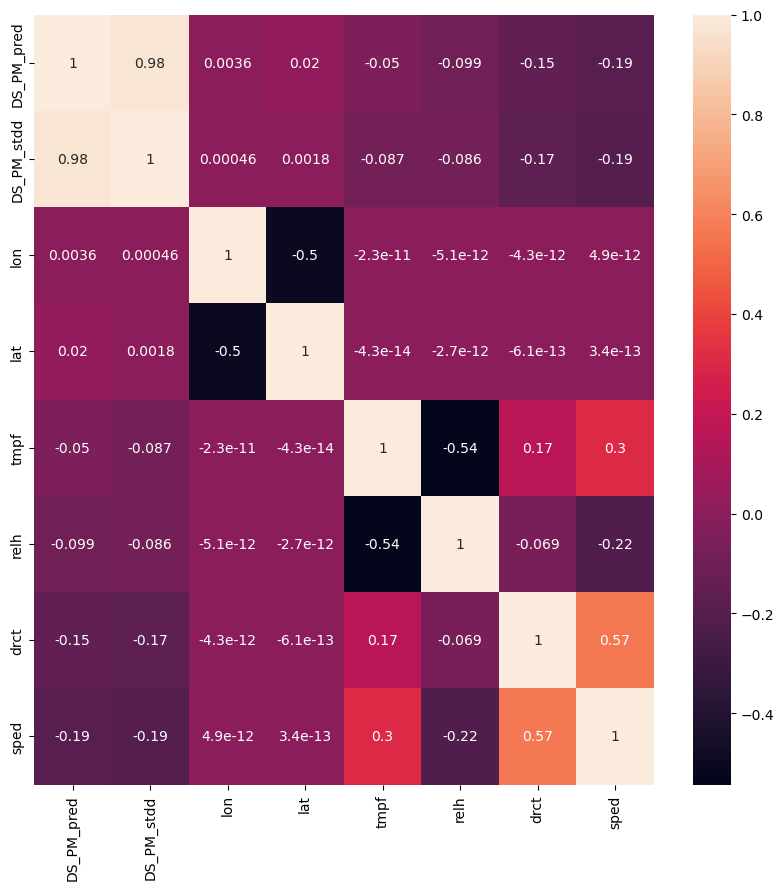

In [9]:
%matplotlib inline
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), annot=True)
plt.show()

The following is a test on linear regression.

For 'sm.OLS' we need the datetime to be a float.

In [10]:
df['valid'] = [dt.replace(tzinfo=timezone.utc).timestamp() for dt in df['valid']]

In [11]:
df.head()

,date,DS_PM_pred,DS_PM_stdd,lon,lat,valid,tmpf,relh,drct,sped
84917819,2019-01-01,4.028,2.1545,-122.5131,37.86929,1.546304e+09,54.0,41.11,350.0,19.55
84917820,2019-01-01,4.028,2.1545,-122.5131,37.86929,1.546308e+09,54.0,42.98,350.0,21.85
84917821,2019-01-01,4.028,2.1545,-122.5131,37.86929,1.546311e+09,53.0,40.96,350.0,28.75
84917822,2019-01-01,4.028,2.1545,-122.5131,37.86929,1.546315e+09,53.0,42.48,360.0,27.60
84917823,2019-01-01,4.028,2.1545,-122.5131,37.86929,1.546319e+09,52.0,46.25,360.0,21.85


"DS_PM_pred" is our target variable. "date" data is captured in "valid". 

I am leaving out 'DS_PM_stdd': Standard error of the estimated PM2.5 concentration because it is not a physical metric, rather highly derivative of "DS_PM_pred". Note the $R^2$ would be .9 if 'DS_PM_stdd' were included.

In [12]:
#X = df.drop(["DS_PM_pred", "DS_PM_stdd",'date','lon','lat'],axis=1)
X = df.drop(["DS_PM_pred","DS_PM_stdd",'date'],axis=1)
X = sm.add_constant(X)

In [13]:
y = df[["DS_PM_pred"]]

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 123)

In [15]:
model = sm.OLS(y_train.astype(float), X_train.astype(float))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             DS_PM_pred   R-squared:                       0.070
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                 3.378e+04
Date:                Sat, 20 Jan 2024   Prob (F-statistic):               0.00
Time:                        17:28:27   Log-Likelihood:            -1.2100e+07
No. Observations:             3123792   AIC:                         2.420e+07
Df Residuals:                 3123784   BIC:                         2.420e+07
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        573.1091     21.510     26.643      0.000     530.949     615.269
lon            5.4223      0.191     28.389      0.000       5.048       5.797
lat            5.3397      0.118     45.104      0.000       5.108       5.572
valid      -5.075e-08   3.67e-10   -138.218      0.000   -5.15e-08      -5e-08
tmpf          -0.1289      0.001   -114.013      0.000      -0.131      -0.127
relh          -0.1510      0.001   -280.657      0.000      -0.152      -0.150
drct          -0.0064   7.54e-05    -85.376      0.000      -0.007      -0.006
sped          -0.3013      0.001   -251.389      0.000      -0.304      -0.299
==============================================================================
Omnibus:                  4009032.587   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        669304852.851
Skew:                           7.269   Prob(JB):                         0.00
Kurtosis:                      73.220   Cond. No.                     5.05e+12
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.05e+12. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Given the $R^2$ value is so small, perhaps a linear regression is not the way to go. A neural net with some short term memory for previous days should be factored into the PM2.5 reading, more so than the weather factors of the current day/reading.

As a silly excercise: a graph of the predicted vs actual data in the linear regression, with red being a perfect match.

In [16]:
rModel = linear_model.LinearRegression()
rModel.fit(X_train, y_train)
rModel.score(X_train, y_train)

0.07037522738133006

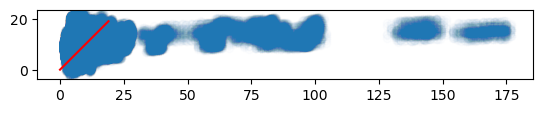

In [17]:
y_pred = rModel.predict(X_test)
plt.scatter(y_test,y_pred,alpha=.01)
plt.plot([x for x in range(0,20)],[x for x in range(0,20)], color='red')
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')
plt.show()

The graph shows that a fitting to a line is not an accurate model.

For a future model involving machine learning, I plan on spliting the timestamp of 'valid' into its constitutes (or scaling the feature). I will also think about assigning unique categories to each unique location (~221 locations).

In [18]:
from sklearn.preprocessing import StandardScaler

In [19]:
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.fit_transform(X_test)

In [20]:
rModel.fit(X_train_sc, y_train)
rModel.score(X_train_sc, y_train)

0.07037522738133029

Scaling doesn't seem to affect the R^2 score.

Below I test some other linear models and use cross validation.

In [21]:
from sklearn.model_selection import KFold, cross_val_score

C:\Users\Whyme\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.16465e-22): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
C:\Users\Whyme\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.16395e-22): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
C:\Users\Whyme\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.16358e-22): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
C:\Users\Whyme\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=1.16336e-22): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T
C:\Users\Whyme\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAl

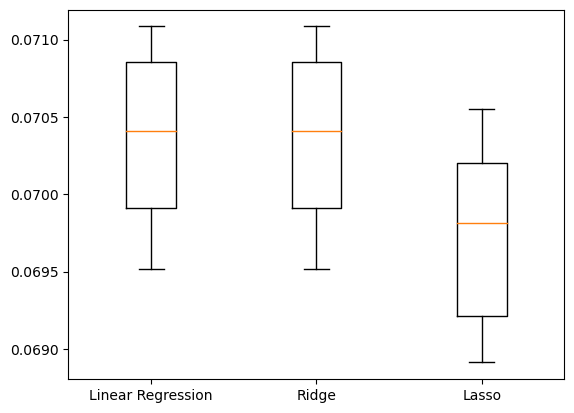

In [27]:
models = {"Linear Regression": linear_model.LinearRegression(), "Ridge": linear_model.Ridge(alpha=0.1), "Lasso": linear_model.Lasso(alpha=0.1)}
results = []
# Loop through the models' values
for model in models.values():
  kf = KFold(n_splits=6, random_state=42, shuffle=True)
  
  # Perform cross-validation
  cv_scores = cross_val_score(model, X_train, y_train, cv=kf)
  
  # Append the results
  results.append(cv_scores)

# Create a box plot of the results
plt.boxplot(results, labels=models.keys())
plt.show()

In general, the scores are too low to be considered.